In [41]:
import ee
ee.Initialize()

import geemap
import pandas as pd
import geopandas as gpd
import numpy as np 

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

pd.options.display.float_format = '{:.3f}'.format

## 1 - input parameters

In [42]:
ISO = 'GAB'

In [43]:
classified_image = ee.Image('projects/ee-obameconanvassily/assets/Classification_GAB_OS2023')

In [44]:
# resolution of the map
scale = 30

In [45]:
# band name for classification
map_band = 'class'

In [46]:
# CEO data
interpretedData = pd.read_csv('/home/sepal-user/module_results/esbae/GAB/GAB_all_ceo_1522_phaseI_II_stable_val.csv', low_memory=False)
interpretedData.columns

Index(['ID', 'plotid_orig', 'CEO_PLOTID', 'lon', 'lat', 'ISO', 'CEO_Ref_Code',
       'Ref_FNF_2015', 'Ref_LCover', 'Ref_Change_Type_1520', 'Ref_Year_1520',
       'countDrivers', 'InfraR', 'Urb', 'ArtAg', 'IndAg', 'ArtFor', 'IndFor',
       'ArtMine', 'IndMine', 'Other', 'Source', 'Ref_Change_Year_1520',
       'Change_Bin_1520', 'UniqueID', 'interpreted', 'sampling', 'ID.1',
       'plotid', 'sampleid', 'sample_geom', 'point_id', 'Ref_Regeneration',
       'Ref_Change_1522', 'Ref_Change_Type_1522', 'Other_Desc',
       'Ref_Year_1522', 'collection', 'Ref_Change_Year_1522', 'Stable_Forest',
       'Ref_Change_Type', 'Ref_Year', 'Ref_Change_Year', 'Ref_Change_Bin',
       'Ref_FNFW', 'split'],
      dtype='object')

In [47]:
# column with LC code
ref_column = 'Ref_LCover'

In [48]:
# name out class area outputs file
area_out = '/home/sepal-user/module_results/esbae/GAB/GAB_LCmap2023_areas.csv'

In [49]:
#name of output file with reference and map data
table_out = '/home/sepal-user/module_results/esbae/GAB/GAB_LCmap2023_ceo_ref_val.csv'

In [50]:
#name of output error matrix
matrix_out = '/home/sepal-user/module_results/esbae/GAB/GAB_LCmap2023_ceo_ref_val_matrix.csv'

### 2 - Get map areas

In [51]:
# Add the area for each pixel
pixelArea = ee.Image.pixelArea()
# Multiply pixel area by the class to get the area per class
area_image = pixelArea.addBands(classified_image)

In [52]:
# Reduce the region by summing up the areas per class
class_areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
    geometry=classified_image.geometry(),
    scale=30,  # Adjust scale according to your image resolution
    maxPixels=1e12
)

In [53]:
# Extract the result
class_areas_dict = class_areas.getInfo()

# Optional: Convert the result to hectares
for item in class_areas_dict['groups']:
    area_ha = item['sum'] / 10000  # 1 hectare = 10,000 square meters
    print(f"Class {item['class']}: {area_ha} hectares")

Class 1: 23783673.486965053 hectares
Class 3: 13.94291495361328 hectares
Class 7: 112201.29230247192 hectares
Class 8: 758.642247076416 hectares
Class 13: 2089545.719115277 hectares
Class 14: 20.915537774658205 hectares
Class 15: 101.97584118652344 hectares
Class 17: 177.24896954345704 hectares
Class 18: 309529.3252661865 hectares


In [66]:
# Convert dictionary to DataFrame
areas_df = pd.DataFrame(class_areas_dict['groups'])
areas_df = areas_df.rename(columns={'sum': 'Area_Ha'})

### 3 sample map with validation points 

In [54]:
gdf = gpd.GeoDataFrame(interpretedData[['ID', ref_column, 'lon', 'lat']], geometry=gpd.points_from_xy(interpretedData.lon, interpretedData.lat), crs='epsg:4326')
gdf

,ID,Ref_LCover,lon,lat,geometry
0,4417,1,13.146,-2.182,POINT (13.14608 -2.18156)
1,4418,1,11.683,2.027,POINT (11.68287 2.02676)
2,4419,1,12.281,-0.185,POINT (12.28127 -0.18474)
3,4420,1,13.812,-2.009,POINT (13.81178 -2.00856)
4,4421,1,10.862,-1.497,POINT (10.86232 -1.49653)
...,...,...,...,...,...
2746,9139,12,11.285,-2.528,POINT (11.28487 -2.52763)
2747,9140,12,14.128,-1.681,POINT (14.12810 -1.68087)
2748,9141,12,9.356,-0.106,POINT (9.35624 -0.10635)
2749,9142,12,11.399,-2.499,POINT (11.39942 -2.49875)


### be patient this can take a while with a large number of points

In [55]:
dfs = []
for i in range(0, len(interpretedData), 5000):
    tmp_df = gdf.loc[i:i+4999]
    tmp_fc = geemap.gdf_to_ee(tmp_df[['ID', ref_column, 'geometry']])
    tmp_smp = classified_image.select(map_band).reduceRegions(**{
        'collection': tmp_fc,
        'scale': scale,
        'reducer': ee.Reducer.first()   
    })

    tmp_res = geemap.ee_to_gdf(tmp_smp)
    dfs.append(tmp_res)
    
results_df = pd.concat(dfs)
#results_df.to_csv(table_out, index=False)

In [56]:
results_df = result_df.rename(columns={'first':'Map_LCover'})
results_df

,geometry,ID,Ref_LCover,Map_LCover
0,POINT (13.14608 -2.18156),4417,1,1
1,POINT (11.68287 2.02676),4418,1,1
2,POINT (12.28127 -0.18474),4419,1,1
3,POINT (13.81178 -2.00856),4420,1,1
4,POINT (10.86232 -1.49653),4421,1,1
...,...,...,...,...
2746,POINT (11.28487 -2.52763),9139,12,13
2747,POINT (14.12810 -1.68087),9140,12,13
2748,POINT (9.35624 -0.10635),9141,12,1
2749,POINT (11.39942 -2.49875),9142,12,13


In [57]:
#export
results_df.to_csv(table_out,index=False)

In [58]:
labels = [1,2,3,4,7,8,9,10,11,12,13,14,15,16,17,18]

In [59]:
conf_matrix = confusion_matrix(results_df['Ref_LCover'], results_df['Map_LCover'], labels=labels)

In [60]:
cm_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#print(cm_df)

In [61]:
#export
cm_df.to_csv(matrix_out,index=True)

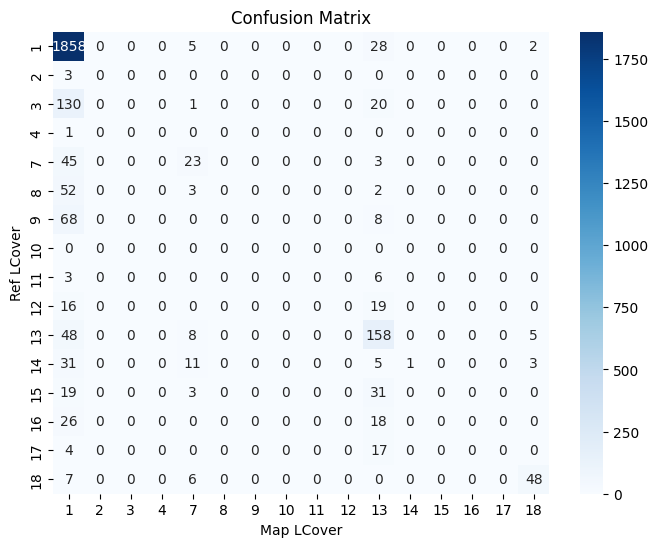

In [62]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Ref LCover')
plt.xlabel('Map LCover')
plt.title('Confusion Matrix')
plt.show()